In [54]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm

# reproducibility
np.random.seed(20886025)

In [55]:
def plot_multiple(title, t, S_pep, S_ko):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(title, y=1.05)
 
    ax0 = axes[0]
    ax0.plot(t, S_pep, alpha=0.05, color='royalblue', label='PEP paths')
    ax0.plot(t, S_ko, alpha=0.15, color='orange', label='KO paths')
    ax0.set_xlabel('Time (years)')
    ax0.set_ylabel('Price')
    ax0.set_title('Simulated Paths for KO and PEP')
    ax0.grid(True)
 
    ax1 = axes[1]
    ax1.scatter(S_ko, S_pep, alpha=0.6, color='grey', edgecolor='black')
    ax1.set_xlabel('PEP Price')
    ax1.set_ylabel('KO Price')
    ax1.set_title(f'PEP vs KO Scatterplot')
    ax1.grid(True)
 
    plt.tight_layout()
    plt.show()

In [56]:
# load data
KO = pd.read_csv('Data/KO Historical Stock Price.csv')
PEP = pd.read_csv('Data/PEP Historical Stock Price.csv')

KO['log_price'] = np.log(KO['close'])
PEP['log_price'] = np.log(PEP['close'])

# this is daily gross returns
KO['daily_return'] = KO['close'] / KO['close'].shift(1)
PEP['daily_return'] = PEP['close'] / PEP['close'].shift(1)

KO['log_return'] = np.log(KO['daily_return'])
PEP['log_return'] = np.log(PEP['daily_return'])

# filter to even out the timeframes
# we want closing price since it's the finalized price per day
# this is the last 10 years of data, starting from June of 1972
start = "2015-09-29"

KO = KO[KO["date"] >= start]
PEP = PEP[PEP["date"] >= start]

'''
year_start = "2025-01-01"

KO = KO[KO["date"] < year_start]
PEP = PEP[PEP["date"] < year_start]
'''

KO = KO.reset_index(drop=True)
PEP = PEP.reset_index(drop=True)

print(PEP.head())

         date     open     high      low    close   volume  log_price  \
0  2015-09-29  68.6494  69.2503  68.4714  69.0129  4177713   4.234293   
1  2015-09-30  69.7695  70.0217  69.3763  69.9475  4356772   4.247745   
2  2015-10-01  69.8733  70.0958  69.0796  69.6137  3754615   4.242961   
3  2015-10-02  69.1094  69.8882  68.6346  69.8437  3830203   4.246260   
4  2015-10-05  70.4000  71.1937  70.1627  71.0676  4228155   4.263632   

   daily_return  log_return  
0      1.006164    0.006145  
1      1.013542    0.013452  
2      0.995228   -0.004784  
3      1.003304    0.003299  
4      1.017523    0.017372  


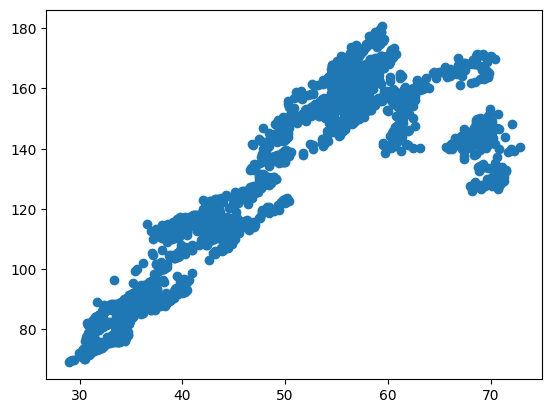

In [57]:
plt.scatter(KO['close'], PEP['close'])

In [58]:
# check correlation between closing prices
correlation = KO['close'].corr(PEP['close'])
print("Daily Price Correlation:", correlation)

# check correlation between the returns
correlation = KO['daily_return'].corr(PEP['daily_return'])
print("Daily Return Correlation:", correlation)

Daily Price Correlation: 0.8950243852262415
Daily Return Correlation: 0.7274898776133543


The prices are significantly more highly correlated than the returns are, but this is most likely due to how both stock prices will have an upward drift/trend in general (more often than not due to inflation), which is something we want to exclude in our modelling, as we are more interested in short-term movements. Using daily returns removes this superfluous information, so we'll use that instead.

Assume that KO and PEP stock prices both follow a GBM. Then we need to determine the drift and volatility of their processes, or equivalently, the drift and volatility of their logarithmic daily returns. Given that we assume a lognormal distribution for the stock price, equivalently a normal distribution for the returns, it can be shown that the MLE for the volatility is the sample standard deviation of the log returns, and the MLE for the drift is the sample mean plus half of the sample variance, while accounting for the timesteps (daily data).

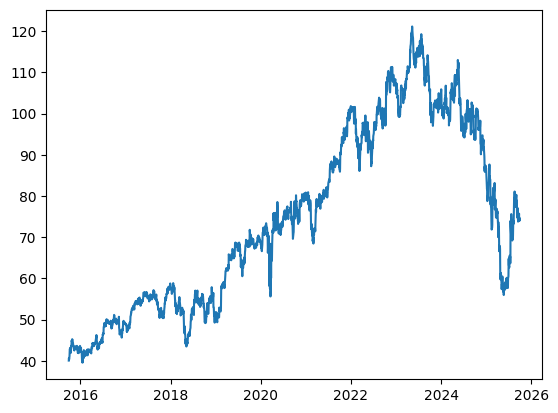

In [59]:
# For this case, let the timesteps be based on yearly periods, or 252 business days
# daily timestep is then 1/252
dt = 1/252
n = 252
T = 10

# first get estimates for KO, dividing by dt to annualize
KO_vol = np.sqrt(np.var(KO['log_return'])/dt)
KO_mu = np.mean(KO['log_return'])/dt + 0.5 * KO_vol**2

# similarly, get estimates for PEP
PEP_vol = np.sqrt(np.var(PEP['log_return'])/dt)
PEP_mu = np.mean(PEP['log_return'])/dt + 0.5 * KO_vol**2

# also get estimates for the spread's log returns
spread = np.array(PEP['close'] - KO['close']).astype(float)
spread_returns = np.log(spread[1:] / spread[:-1])[1:]
spread_vol = np.sqrt(np.var(spread_returns)/dt)
spread_mu = np.mean(spread_returns)/dt + 0.5 * spread_vol**2

plt.plot(pd.to_datetime(KO['date']), spread)

In [60]:
# one 60-day simulation
T = 1
n = 10000

# for daily, we have 60 steps
steps = 60
t = np.linspace(0, T, steps)
step_size = T/steps

# KO
KO_init = KO['close'].iloc[-1]
KO_mu = KO_mu
KO_sig = KO_vol

# PEP
PEP_init = PEP['close'].iloc[-1]
PEP_mu = PEP_mu
PEP_sig = PEP_vol

# spread
spread_init = spread[-1]
spread_mu = spread_mu
spread_sig = spread_vol

With these parameters, we can now perform 3 simulations: modelling the spread itself as a GBM, modelling the KO and PEP prices as uncorrelated random walks, and modelling them as correlated random walks.

We start with simply modelling the spread itself as a GBM.

In [61]:
# setup for GBM spread simulation
spread_U = np.random.uniform(0, 1, size=(n, steps))
spread_dW = norm.ppf(spread_U)

# the return, lognormal stock means the stock price will have exponential factor, which is the log returns
# to get daily returns, just exponentiate
spread_returns = np.exp((spread_mu - 0.5 * spread_sig**2) * step_size * np.ones((n, steps)) + spread_sig * spread_dW * sqrt(step_size))

gbm_spread = spread_init * np.cumprod(spread_returns, 1)

Now, we'll simulate KO and PEP prices as uncorrelated random walks.

In [62]:
# setup for uncorrelated random walk simulation

# creating the noise variable using inverse CDF transform
# use standard normal CDF since the errors are assumed to be white noise
KO_U = np.random.uniform(0, 1, size=(n, steps))
KO_dW = norm.ppf(KO_U)

PEP_U = np.random.uniform(0, 1, size=(n, steps))
PEP_dW = norm.ppf(PEP_U)

# the return, lognormal stock means the stock price will have exponential factor, which is the log returns
# to get daily returns, just exponentiate
KO_returns = np.exp((KO_mu - 0.5 * KO_sig**2) * step_size * np.ones((n, steps)) + KO_sig * KO_dW * sqrt(step_size))
PEP_returns = np.exp((PEP_mu - 0.5 * PEP_sig**2) * step_size * np.ones((n, steps)) + PEP_sig * PEP_dW * sqrt(step_size))

# get cumulative sum of the exponents, then exponentiate to simulate daily returns analytically
KO_final = KO_init * np.cumprod(KO_returns, 1)
PEP_final = PEP_init * np.cumprod(PEP_returns, 1)

# get spread
uncorrelated_spread = PEP_final - KO_final

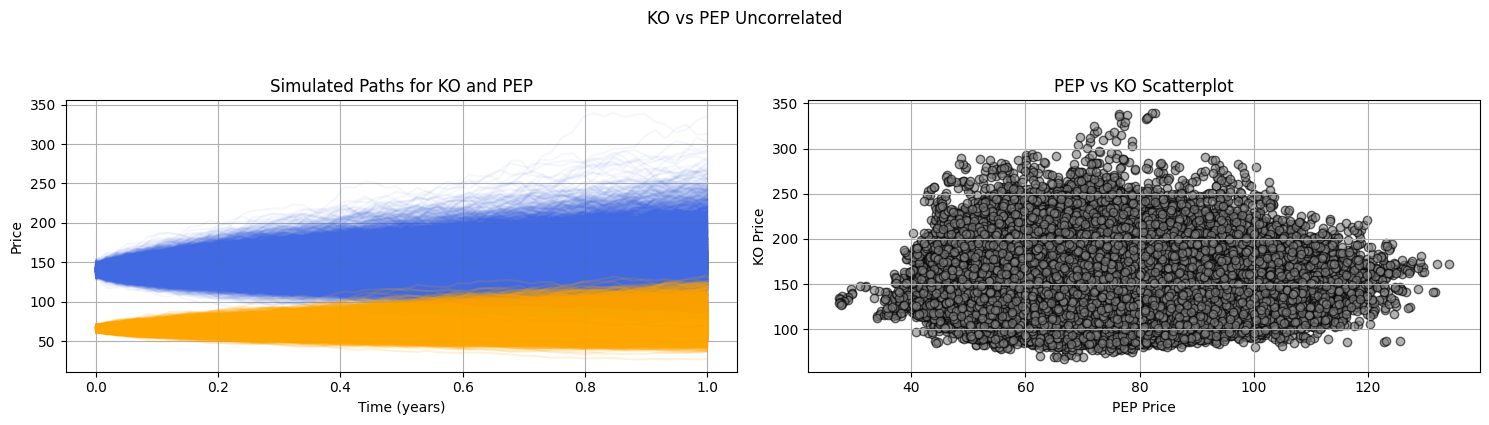

In [63]:
plot_multiple("KO vs PEP Uncorrelated", t, PEP_final.T, KO_final.T)

Next, we'll simulate PEP and KO prices as correlated random walks with the calculated correlation between their returns from earlier.

In [64]:
# setup for correlated random walk simulation

# creating the noise variable using inverse CDF transform
# use standard normal CDF since the errors are assumed to be white noise
KO_U = np.random.uniform(0, 1, size=(n, steps))
KO_dW = norm.ppf(KO_U)

PEP_U = np.random.uniform(0, 1, size=(n, steps))
PEP_dW = norm.ppf(PEP_U)

randoms = np.stack((KO_dW, PEP_dW), axis=1)

# now we want to correlate the random noises
# create correlation matrix
rho = correlation
C = [[1, rho],
     [rho, 1]]
L_low = np.linalg.cholesky(C)

L_lows = np.repeat(L_low[np.newaxis, :, :], n, axis=0)

out = L_lows @ randoms

KO_dW = out[:, 0, :]
PEP_dW = out[:, 1, :]

# the return, lognormal stock means the stock price will have exponential factor, which is the log returns
# to get daily returns, just exponentiate
KO_returns = np.exp((KO_mu - 0.5 * KO_sig**2) * step_size * np.ones((n, steps)) + KO_sig * KO_dW * sqrt(step_size))
PEP_returns = np.exp((PEP_mu - 0.5 * PEP_sig**2) * step_size * np.ones((n, steps)) + PEP_sig * PEP_dW * sqrt(step_size))

# get cumulative sum of the exponents, then exponentiate to simulate daily returns analytically
KO_final = KO_init * np.cumprod(KO_returns, 1)
PEP_final = PEP_init * np.cumprod(PEP_returns, 1)

# get correlated spread
correlated_spread = PEP_final - KO_final

In [65]:
print(randoms.shape)
print(L_lows.shape)

(10000, 2, 60)
(10000, 2, 2)


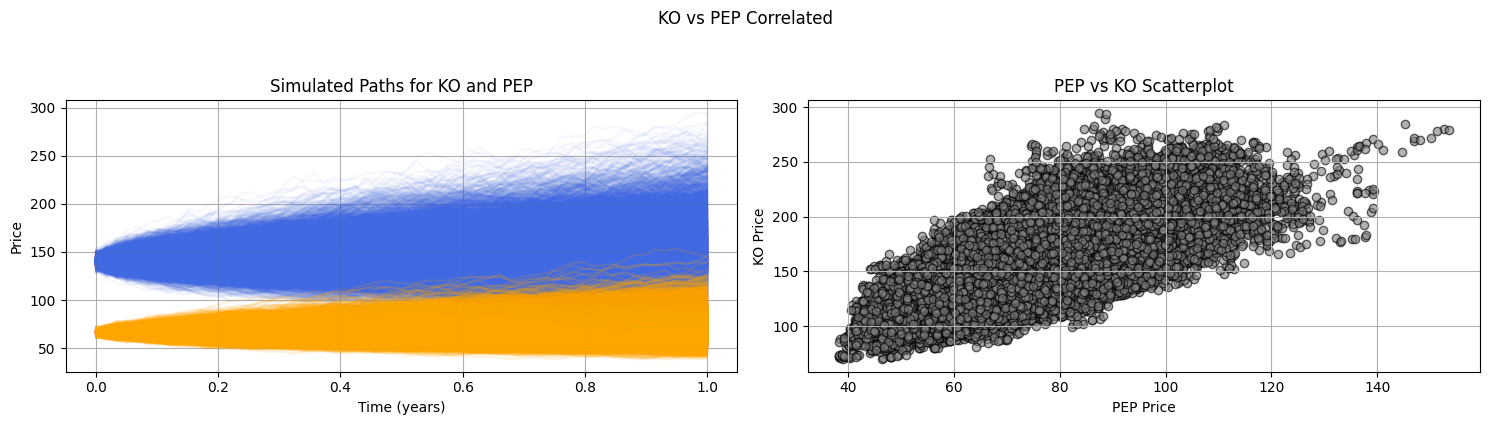

In [66]:
plot_multiple("KO vs PEP Correlated", t, PEP_final.T, KO_final.T)

Let's compare the 3 differently modelled spreads:

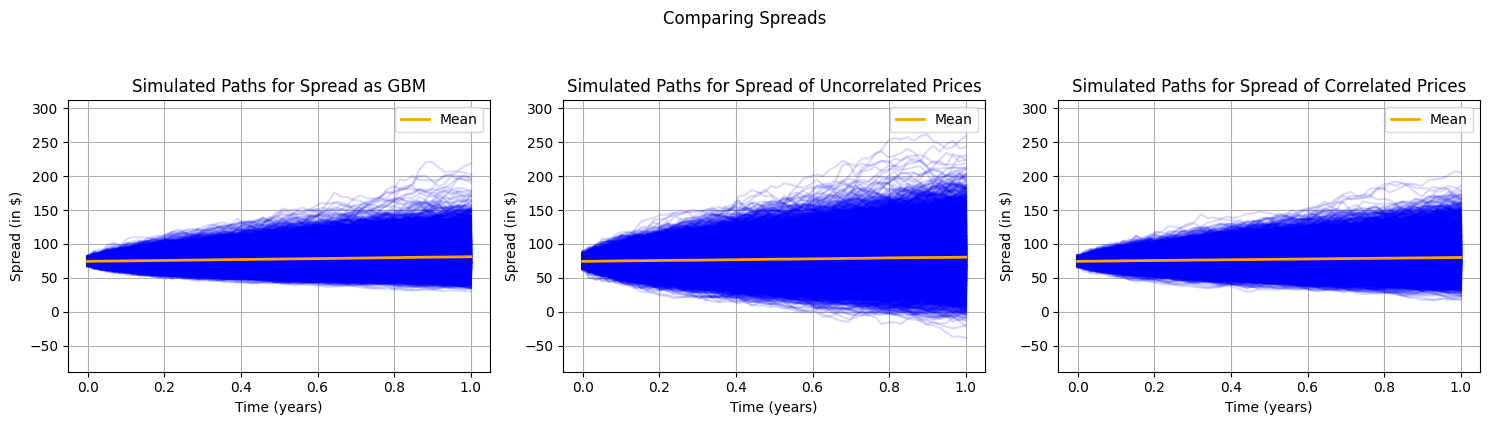

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Comparing Spreads", y=1.05)

ax0 = axes[0]
ax0.plot(t, gbm_spread.T, alpha=0.15, color='blue')
ax0.plot(t, np.mean(gbm_spread.T, axis=1), color='orange', lw=2, label='Mean')
ax0.set_xlabel('Time (years)')
ax0.set_ylabel('Spread (in $)')
ax0.set_title('Simulated Paths for Spread as GBM')
ax0.legend()
ax0.grid(True)

ax1 = axes[1]
ax1.plot(t, uncorrelated_spread.T, alpha=0.15, color='blue')
ax1.plot(t, np.mean(uncorrelated_spread.T, axis=1), color='orange', lw=2, label='Mean')
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Spread (in $)')
ax1.set_title('Simulated Paths for Spread of Uncorrelated Prices')
ax1.legend()
ax1.grid(True)

ax2 = axes[2]
ax2.plot(t, correlated_spread.T, alpha=0.15, color='blue')
ax2.plot(t, np.mean(correlated_spread.T, axis=T), color='orange', lw=2, label='Mean')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Spread (in $)')
ax2.set_title('Simulated Paths for Spread of Correlated Prices')
ax2.legend()
ax2.grid(True)

y_min = min(gbm_spread.min(), uncorrelated_spread.min(), correlated_spread.min())
y_max = max(gbm_spread.max(), uncorrelated_spread.max(), correlated_spread.max())
for ax in axes:
    ax.set_ylim(y_min - 50, y_max + 50)

plt.tight_layout()
plt.show()

What if we tried using an OU model to model the spread? Let's first examine the spread more closely:


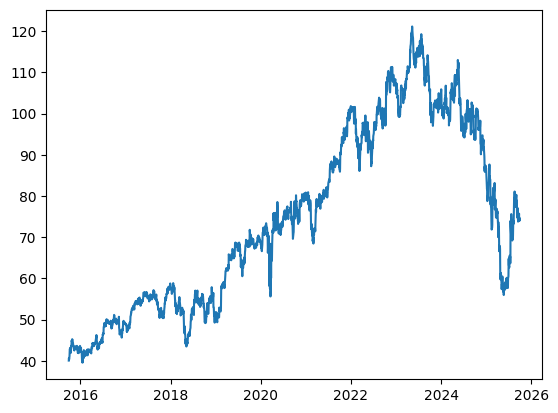

In [68]:
spread = PEP['close'] - KO['close']
plt.plot(pd.to_datetime(KO['date']), spread)

We need to find the parameters for the corresponding model that fits our spread the most effectively. To do so, we first regress PEP on KO. 

In [69]:
# regress PEP on KO, no intercept because the beta represents the hedge ratio
X = KO['close']
y = PEP['close']
model = sm.OLS(y, X).fit()
new_spread = model.resid
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  close   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.889e+05
Date:                Fri, 10 Oct 2025   Prob (F-statistic):                        0.00
Time:                        11:21:52   Log-Likelihood:                         -10270.
No. Observations:                2515   AIC:                                  2.054e+04
Df Residuals:                    2514   BIC:                                  2.055e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [70]:
# estimate the mean of OU as the long-term mean of the spread
OU_mean = np.mean(new_spread)

# estimate the mean reversion factor through the autocorrelation of the time series
dt = 1/252 # daily data, simulation is only going to be for a 252-day period
OU_revert = -np.log(np.corrcoef(new_spread[:-1], new_spread[1:])[0, 1])/dt

# estimate the std using the sample variance
OU_std = np.sqrt(np.var(new_spread))

print(OU_mean, OU_revert, OU_std)

0.4415439083116797 0.7084450334512348 14.356852506081493


In [71]:
# setup for OU spread simulation
OU_spread_U = np.random.uniform(0, 1, size=(n, steps))
OU_spread_dW = norm.ppf(OU_spread_U)

# use Euler approximation
OU_spread = np.zeros((n, steps))
# set initial value to most recent spread in training data
OU_spread[:, 0] = new_spread.iloc[-1] + OU_revert*(OU_mean - new_spread.iloc[-1]) * step_size + OU_std * np.sqrt(step_size) * OU_spread_dW[:, 0]

# simulate
for i in range(1, steps):
    OU_spread[:, i] = OU_spread[:, i-1] + OU_revert*(OU_mean - OU_spread[:, i-1]) * step_size + OU_std * np.sqrt(step_size) * OU_spread_dW[:, i]

print(OU_spread)

[[-27.86090874 -26.03054161 -27.21833671 ... -12.91844975 -14.35668972
  -15.66862262]
 [-30.32735822 -30.83163116 -26.87546143 ... -10.42268899  -9.74733811
  -11.23967858]
 [-31.40514876 -29.08361743 -28.79399703 ... -19.52843828 -21.58856036
  -18.49169078]
 ...
 [-29.91782837 -28.52602472 -28.75970539 ... -10.51140285 -11.31858059
  -12.92899822]
 [-30.54135906 -28.69837495 -29.13009552 ... -15.28933694 -16.68808459
  -17.86401937]
 [-27.63334704 -28.0101119  -27.95935286 ... -36.73525933 -39.77720176
  -35.77572934]]


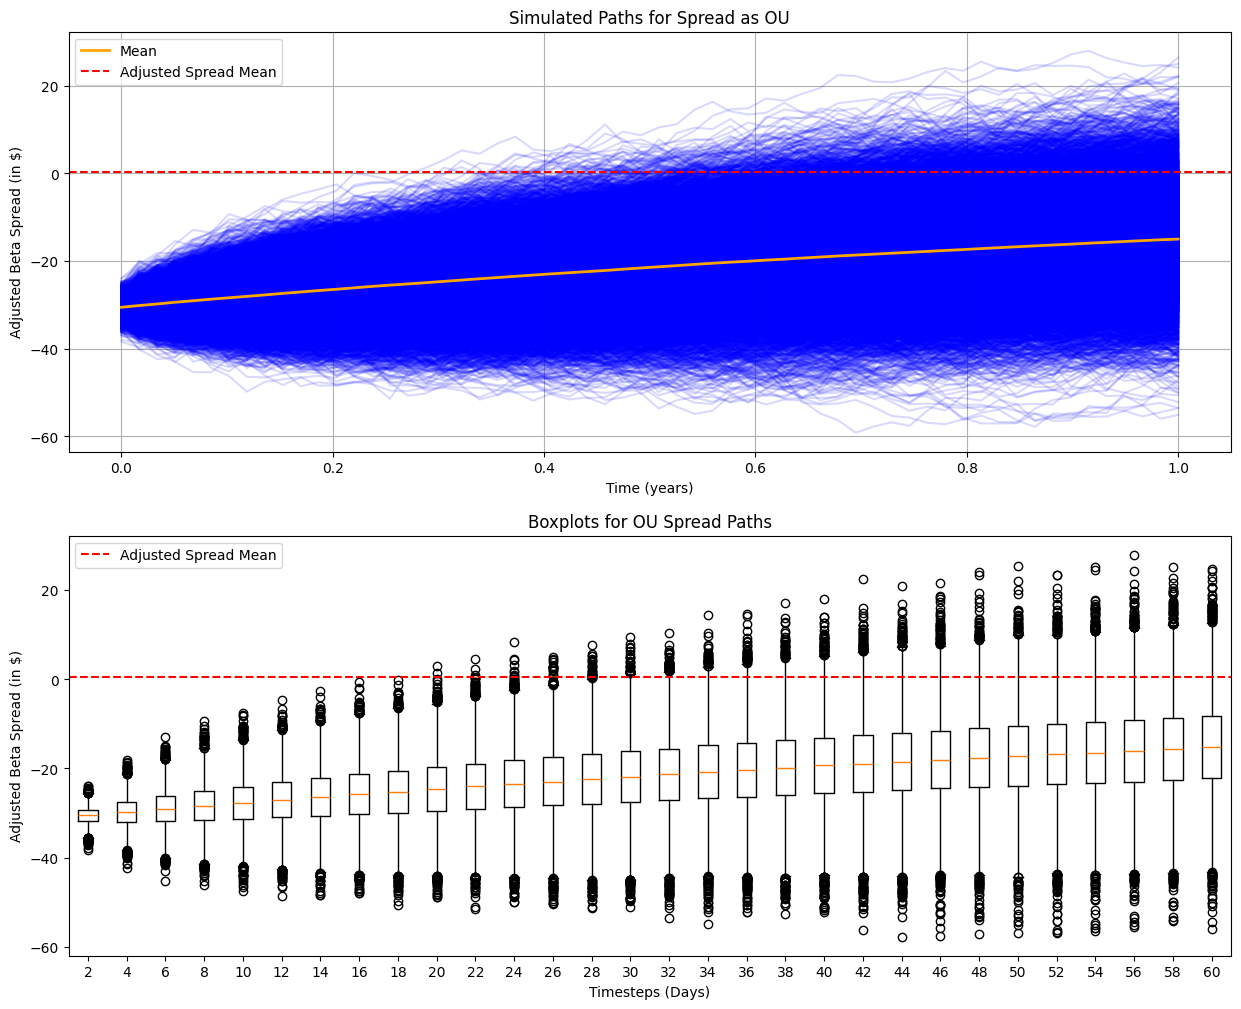

In [72]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

ax0 = axes[0]
ax0.plot(t, OU_spread.T, alpha=0.15, color='blue')
ax0.plot(t, np.mean(OU_spread, axis=0), color='orange', lw=2, label='Mean')
ax0.axhline(OU_mean, color='red', linestyle='dashed', label='Adjusted Spread Mean')
ax0.set_xlabel('Time (years)')
ax0.set_ylabel('Adjusted Beta Spread (in $)')
ax0.set_title('Simulated Paths for Spread as OU')
ax0.legend()
ax0.grid(True)

step = max(1, len(t)//30)
idxs = np.arange(0, len(t), step)
selected_box = OU_spread[:, idxs]

ax1 = axes[1]
ax1.boxplot(selected_box)
ax1.axhline(OU_mean, color='red', linestyle='dashed', label='Adjusted Spread Mean')
ax1.set_xticklabels([2*i for i in range(1, 31)])
ax1.set_xlabel('Timesteps (Days)')
ax1.set_ylabel('Adjusted Beta Spread (in $)')
ax1.set_title('Boxplots for OU Spread Paths')
ax1.legend()

Overall, the OU model appears to be reverting towards the mean spread of around 0.4, and appears to be bounded at the top and bottom by 20 and -60.

In order to determine the 5th percentile, 95th percentile, and mean of the PNL, we will need to do a backtest.

In [73]:
# define our backtest function on the simulated OU paths
def backtest(days, paths, init, mean, shares, enter_long, enter_short):
    n = paths.shape[0]
    pnls = np.zeros(n)
    
    for j in range(n):
        short = False
        long = False

        pos = 0

        # set up an initial position, we're definitely entering the trade
        if init > mean:
            short = True
        else:
            long = True
        pos = init

        for i in range(days):
            if paths[j, i] >= enter_short:
                if long: # flip if already trading and reaching barrier
                    pnls[j] += shares * (paths[j,i] - pos)
                    long = False
                    short = True
                    pos = paths[j, i] # starting point for the newly initiated trade position
            if paths[j, i] <= enter_long:
                if short: # flip if already trading and reaching barrier
                    pnls[j] += shares * (pos - paths[j,i])
                    short = False
                    long = True
                    pos = paths[j,i] # starting point for the newly initiated trade position
        # exit trade after end of period
        if short:
            pnls[j] += shares * (pos - paths[j, days-1])
        if long:
            pnls[j] += shares * (paths[j, days-1] - pos)

    return (round(float(np.quantile(pnls, 0.05)), 2), round(float(np.quantile(pnls, 0.5)), 2), round(float(np.quantile(pnls, 0.95)), 2))

The price differential at which I would enter/exit the trade depends on the graph of the spread after accounting for the beta between KO and PEP. We can observe it and eyeball a few values:

2.8753762162386374
-33.450373117682524


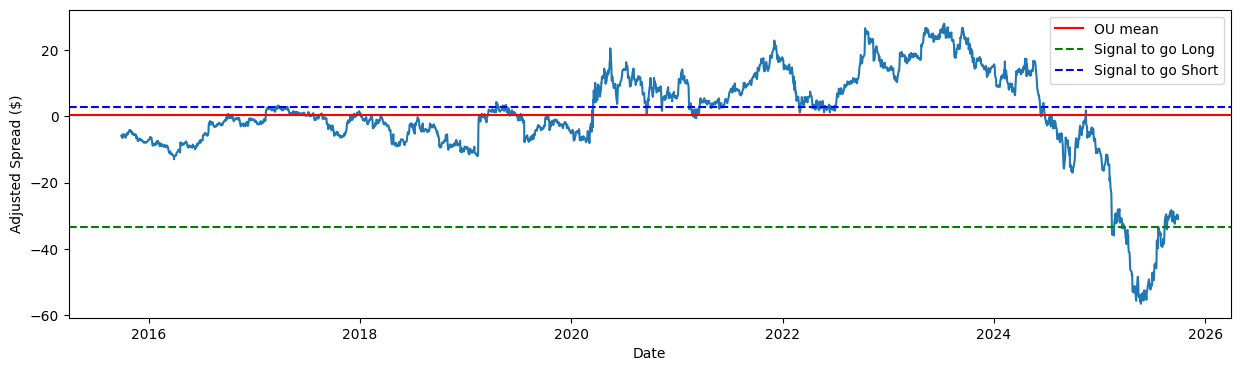

In [74]:
new_spread = model.resid

plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(KO['date']), new_spread)
plt.xlabel("Date")
plt.ylabel("Adjusted Spread ($)")
plt.axhline(np.quantile(new_spread, 0.5), color = 'r', label='OU mean')
plt.axhline(np.quantile(new_spread, 0.04), color = 'g', linestyle = 'dashed', label='Signal to go Long')
plt.axhline(np.quantile(new_spread, 0.6), color = 'b', linestyle = 'dashed', label='Signal to go Short')
plt.legend()

print(np.quantile(new_spread, 0.6))
print(np.quantile(new_spread, 0.04))

Based on where the price is most recently, the adjusted spread at which I'd enter the trade in a short position is thus a value of &#36;2.88, and the adjusted spread at which I'd flip/enter the trade in a long position is -&#36;33.45. This is due to the recent prices significantly impacting the nature of the distribution of the adjusted spread. With this, we can initiate a backtest using our simulated OU paths:

In [75]:
# suppose we enter the trade and exit after a week
days = 5

# initial investment of $100000 in both positions, long and short KO and PEP as is profitable
amt = 100000

# initial spread value
init = new_spread.iloc[-1]

# values to enter/flip at for long/short
enter_long = np.quantile(new_spread, 0.04)
enter_short = np.quantile(new_spread, 0.6)

print(enter_long, enter_short)

# we can compute the number of "shares" we have in this spread, divide invested amount by PEP's current price since we have 1 share of PEP per spread unit
# the spread is basically a synthetic position that goes short in beta shares of KO and long in 1 share of PEP
# we can long or short this position as needed, flip when reaching barriers
shares = 100000/PEP['close'].iloc[-1]

VaR = backtest(days, OU_spread, init, OU_mean, shares, enter_long, enter_short)

print(VaR)

-33.450373117682524 2.8753762162386374
(-3421.01, 1289.24, 6041.22)


So the 5th percentile is a loss of -&#36;3421.01, the expected value of the trade is about -&#36;1289.24, and the 95th percentile is a profit of -&#36;6041.22. However, this is most likely inaccurate, as the global mean for the adjusted spread is so much higher than the slew of recent values in the past year, which are all adjusted spreads in the range of (-60, -20). 

To rectify this, I will try simulating a structural break in 2025, as that appears to be where the behaviour of the spread changed drastically. I'll fit two different hedge ratios, one for KO and PEP prior to 2025, and one for 2025 onward. This implies that a pairs trading strategy using this version of the spread would statically adjust beta again if other structural breaks occurred in the future, in order to maintain the shape of the adjusted spread. 

Pre-break hedge ratio: 2.6847679436308898
Post-break hedge ratio: 2.0451736645355876


C:\Users\JXYTi\AppData\Local\Temp\ipykernel_21432\2815103076.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Pre-break hedge ratio:", model.params[0])
C:\Users\JXYTi\AppData\Local\Temp\ipykernel_21432\2815103076.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Post-break hedge ratio:", model.params[0])


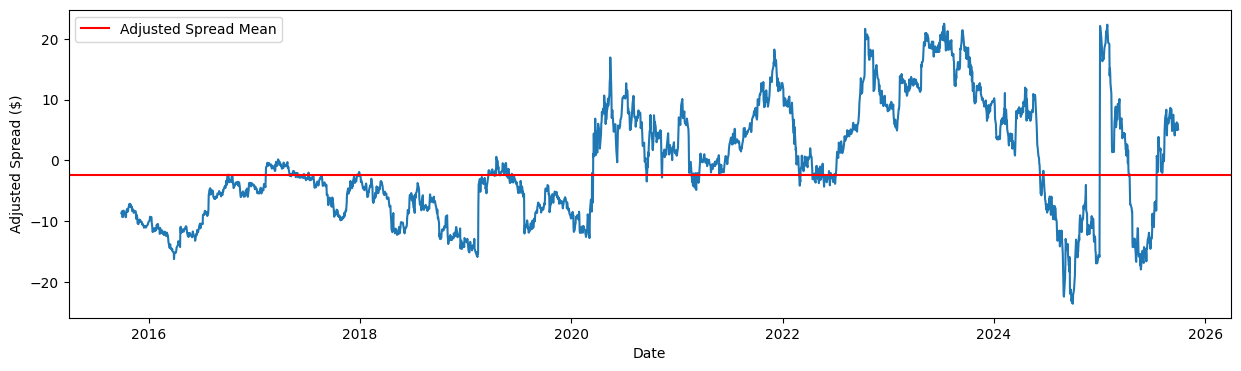

In [76]:
struct_break = '2025-01-01'

KO_before = KO[KO['date'] < struct_break]
KO_after = KO[KO['date'] >= struct_break]
PEP_before = PEP[PEP['date'] < struct_break]
PEP_after = PEP[PEP['date'] >= struct_break]

# before structural break

X = KO_before['close']
y = PEP_before['close']
model = sm.OLS(y, X).fit()
pre_break_spread = model.resid
print("Pre-break hedge ratio:", model.params[0])

X = KO_after['close']
y = PEP_after['close']
model = sm.OLS(y, X).fit()
post_break_spread = model.resid
print("Post-break hedge ratio:", model.params[0])

new_spread = pd.Series(np.concat((pre_break_spread, post_break_spread)))

plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(KO['date']), new_spread)
plt.xlabel("Date")
plt.ylabel("Adjusted Spread ($)")
plt.axhline(np.quantile(new_spread, 0.5), color = 'r', label="Adjusted Spread Mean")
plt.legend()

This looks much better in terms of both bounds and mean reversion, making it significantly better for a mean-reverting model.

In [77]:
# estimate the mean of OU as the long-term mean of the spread
OU_mean = np.mean(new_spread)

# estimate the mean reversion factor through the autocorrelation of the time series
dt = 1/252 # daily data, OU parameters are annualized
OU_revert = -np.log(np.corrcoef(new_spread[:-1], new_spread[1:])[0, 1])/dt

# estimate the std using the sample variance
OU_std = np.sqrt(np.var(new_spread))

print(OU_mean, OU_revert, OU_std)

-0.763891081197687 2.5276003452200304 9.30772194139684


In [78]:
# This time, do 1 million simulations for the real deal
n = 1000000

# setup for OU spread simulation
OU_spread_U = np.random.uniform(0, 1, size=(n, steps))
OU_spread_dW = norm.ppf(OU_spread_U)

# use Euler approximation
OU_spread = np.zeros((n, steps))
# set initial value to most recent spread in training data
OU_spread[:, 0] = new_spread.iloc[-1] + OU_revert*(OU_mean - new_spread.iloc[-1]) * step_size + OU_std * np.sqrt(step_size) * OU_spread_dW[:, 0]

# simulate
for i in range(1, steps):
    OU_spread[:, i] = OU_spread[:, i-1] + OU_revert*(OU_mean - OU_spread[:, i-1]) * step_size + OU_std * np.sqrt(step_size) * OU_spread_dW[:, i]

print(OU_spread)

[[ 3.28177413  1.9464823   2.17881465 ... -2.96597765 -3.17273888
  -2.57126458]
 [ 4.2866192   4.94418192  6.0102067  ... -2.06122641 -3.14136292
  -5.04556154]
 [ 3.37933036  2.5941616   2.49350483 ... -3.33744913 -4.37101313
  -4.74517348]
 ...
 [ 5.44314673  4.19239051  3.88054376 ... -0.10688929 -1.02889985
  -1.4863236 ]
 [ 5.52400451  5.68760463  6.0618924  ...  3.03151174  4.74116531
   4.87381175]
 [ 3.13427408  2.42993355  1.86895025 ...  4.13221491  4.62307042
   3.42779075]]


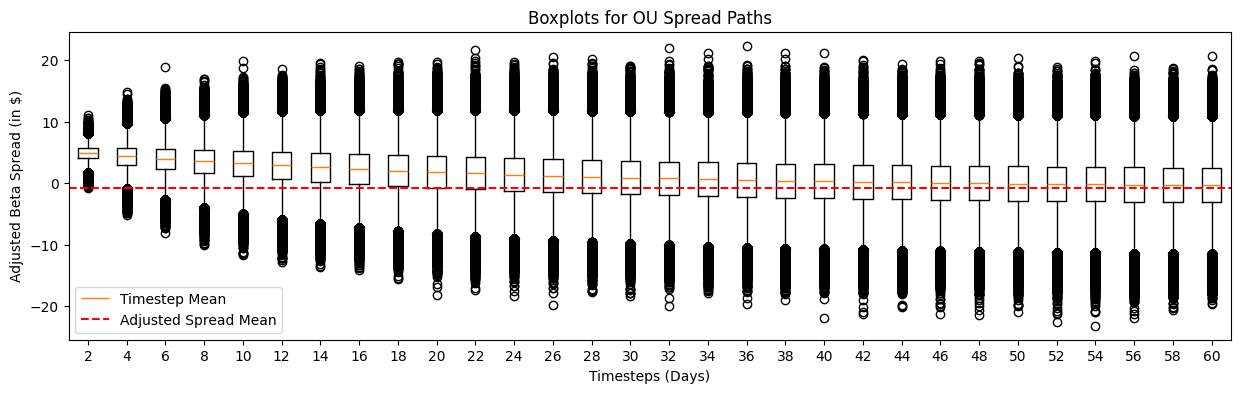

In [79]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

step = max(1, len(t)//30)
idxs = np.arange(0, len(t), step)
selected_box = OU_spread[:, idxs]

ax0 = axes
ax0.boxplot(selected_box, label="Timestep Mean")
ax0.axhline(OU_mean, color='red', linestyle='dashed', label='Adjusted Spread Mean')
ax0.set_xticklabels([2*i for i in range(1, 31)])
ax0.set_xlabel('Timesteps (Days)')
ax0.set_ylabel('Adjusted Beta Spread (in $)')
ax0.set_title('Boxplots for OU Spread Paths')
ax0.legend()

This adjusted spread with two betas (one before and one after the structural break) looks much better with an OU model simulating it. Another look at the graph will tell us what appropriate values for our long and short entry boundaries are:

8.02383058108525
-11.969297993442416


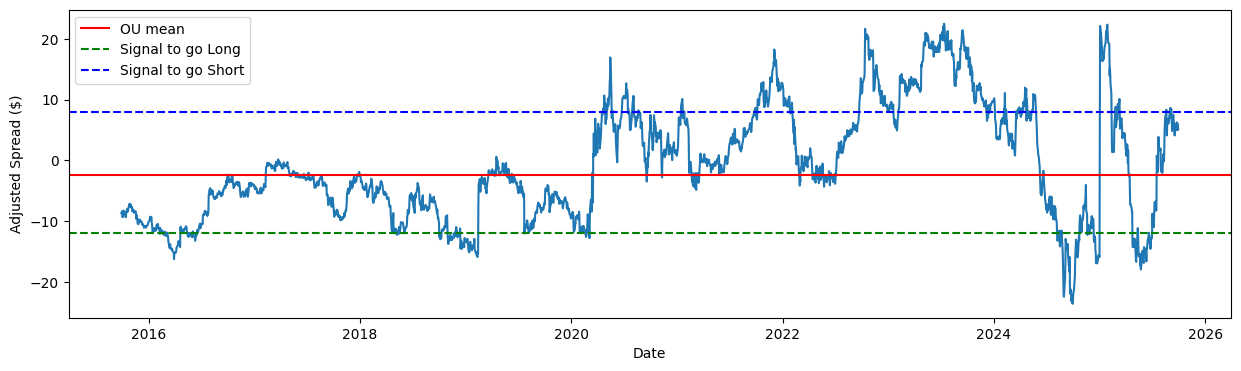

In [80]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(KO['date']), new_spread)
plt.xlabel("Date")
plt.ylabel("Adjusted Spread ($)"),
plt.axhline(np.quantile(new_spread, 0.5), color = 'r', label='OU mean')
plt.axhline(np.quantile(new_spread, 0.1), color = 'g', linestyle = 'dashed', label='Signal to go Long')
plt.axhline(np.quantile(new_spread, 0.8), color = 'b', linestyle = 'dashed', label='Signal to go Short')
plt.legend()

print(np.quantile(new_spread, 0.8))
print(np.quantile(new_spread, 0.1))

My chosen values for a long/short entry in the spread are -&#36;11.97 and &#36;8.02, respectively. Both values encompass most of the critical points where the adjusted spread begins meanreverting while leaving some breathing room for the risk of possible earlier reversions. Finally, let's try a backtest using our simulated paths:

In [ ]:
# suppose we enter the trade and exit after a week/5 trading days
days = 5

# initial investment of $100000 in both positions, long and short KO and PEP as is profitable
amt = 100000

# initial spread value
init = new_spread.iloc[-1]

# values to enter/flip at for long/short
enter_long = np.quantile(new_spread, 0.1)
enter_short = np.quantile(new_spread, 0.8)

print(enter_long, enter_short)

# we can compute the number of "shares" we have in this spread, divide invested amount by PEP's current price since we have 1 share of PEP per spread unit
# the spread is basically a synthetic position that goes short in beta shares of KO and long in 1 share of PEP
# we can long or short this position as needed, flip when reaching barriers
shares = 100000/PEP['close'].iloc[-1]

VaR = backtest(days, OU_spread, init, OU_mean, shares, enter_long, enter_short)

print(VaR)

-11.969297993442416 8.02383058108525
(-2094.11, 811.92, 3718.04)


Thus, under the assumption that we're adjusting our beta value between KO and PEP prices if there are significant structural changes, after 5 days, the 5th percentile profit-loss of initiating a pairs trade on the adjusted spread is -&#36;2094.11, the expected value of that trade is &#36;811.92, and the 95th percentile profit-loss is &#36;3718.04. 